In [2]:
# for reading writing and visulaizing the image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for creating the model
import torch
import torchvisiona
from time import time
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchsummary import summary

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


##### LOADING THE DATASET

In [3]:
dataset = pd.read_csv('data//train.csv')
pred_dataset =  pd.read_csv('data//test.csv')

In [4]:
dataset

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
pred_dataset

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### DEFINING THE DATALOADERS

In [6]:
# .values gives the datasets as numpy arrays and when we give them to dataloaders they automatically transform them to tensors
dataset = dataset.values 
pred_dataset = pred_dataset.values
train_dataset, test_dataset = torch.utils.data.random_split(dataset, (33600, 8400)) # 80% training 
train_dataloader =  DataLoader(train_dataset, batch_size = 16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle= False)

In [7]:
print(next(iter(train_dataloader)).shape)
next(iter(train_dataloader))

torch.Size([16, 785])


tensor([[6, 0, 0,  ..., 0, 0, 0],
        [9, 0, 0,  ..., 0, 0, 0],
        [2, 0, 0,  ..., 0, 0, 0],
        ...,
        [8, 0, 0,  ..., 0, 0, 0],
        [7, 0, 0,  ..., 0, 0, 0],
        [4, 0, 0,  ..., 0, 0, 0]])

In [8]:
print(next(iter(test_dataloader)).shape)
next(iter(test_dataloader))

torch.Size([16, 785])


tensor([[4, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [8, 0, 0,  ..., 0, 0, 0],
        [5, 0, 0,  ..., 0, 0, 0],
        [7, 0, 0,  ..., 0, 0, 0]])

#### DISPLAYING THE IMAGES

In [9]:
def PlotBatch(data_loader, batch_size = 16):
  batch = next(iter(data_loader))  # first batch of data_loader
  fig = plt.figure(figsize=(16,4))
  for i in range(16):
    fig.add_subplot(2,8,i+1)
    temp = batch[i,1:]
    plt.imshow(temp.reshape(28,28), cmap='gray')
    plt.title(batch[i,0].item())
    plt.axis('off')

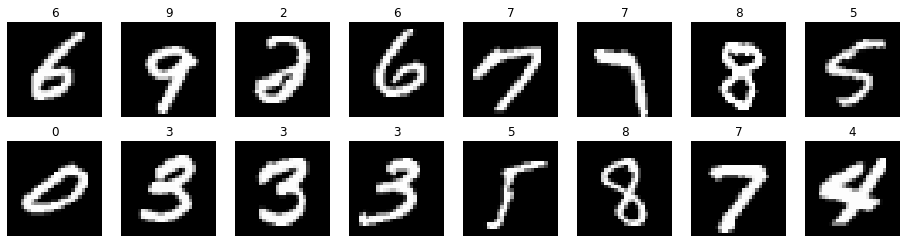

In [10]:
PlotBatch(train_dataloader)

#### MODEL

In [11]:
class MNIST(nn.Module):
  def __init__(self):
    super(MNIST, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(784, 64),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(64, 10)
    ).to(device)
  
  def forward(self, x):
    out = self.model(x)
    return out

In [12]:
model = MNIST().to(device)
summary(model, (784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]          50,240
              ReLU-2                   [-1, 64]               0
           Dropout-3                   [-1, 64]               0
            Linear-4                   [-1, 10]             650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.19
Estimated Total Size (MB): 0.20
----------------------------------------------------------------


In [13]:
def train(epochs, batch_size = 16, print_every = 50):
  total_loss = 0 # average of losses over all of the batches
  accuracy = []
  tic = time()

  for i, batch in enumerate(train_dataloader,1):  # i represents number of batches starting from 1
    model_input = (batch[:,1:]/255.0).to(device)
    target = (batch[:,0]).to(device)

    model_output = model(model_input)
    loss = criterion(model_output, target)
    total_loss+= loss.item()  # as it is just a tensor of 0 dimension, so converting it to a scalar by .item() method
    # backpropoagation
    optimizer.zero_grad() # making the gradients equal to zero if there are previously any
    loss.backward()
    optimizer.step()  # updating the gradients

    res = model_output.argmax(dim=1)
    accuracy.append((res==target).sum().item()/batch_size) # accuracy over a batch

    if i%print_every==0:   # should print something after every 'print_every' no. of batches are processed
      print('Epoch [{}] ({}/{}), train_loss = {:.4f}, accuracy = {:.2f}, time = {:.2f} sec'.format(epoch, i, len(train_dataloader), loss.item(), sum(accuracy)/len(accuracy), time() - tic ))
  return total_loss/len(train_dataloader) # returns average loss of all batches


In [14]:
def test(epochs, batch_size = 16, print_every = 50):
  total_loss = 0
  accuracy = []
  tic = time()
  
  with torch.no_grad():
    for i, batch in enumerate(test_dataloader, 0):
      model_input = (batch[:,1:]/255.0).to(device)
      target = (batch[:,0]).to(device)

      model_output = model(model_input)
      loss = criterion(model_output, target)
      total_loss+= loss.item()

      result = model_output.argmax(dim=1)
      accuracy.append((result==target).sum().item()/target.shape[0]) 
  print('Epoch: [{}], Test Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
        epoch, total_loss/len(test_dataloader), sum(accuracy)/len(accuracy), time()-tic
    ))
  return total_loss/len(test_dataloader) # Returning Average Testing Loss

In [15]:
lr = 1e-4
model = MNIST().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

In [16]:
train_loss = []
test_loss = []
for epoch in range(1, 51):
  train_loss.append(train(epoch, batch_size=16, print_every=500 ))
  test_loss.append(test(epoch, batch_size = 16, print_every=500 ))
  print("\n")

Epoch [1] (500/2100), train_loss = 1.1386, accuracy = 0.59, time = 1.53 sec
Epoch [1] (1000/2100), train_loss = 0.9168, accuracy = 0.68, time = 2.98 sec
Epoch [1] (1500/2100), train_loss = 0.7603, accuracy = 0.73, time = 4.33 sec
Epoch [1] (2000/2100), train_loss = 0.6261, accuracy = 0.76, time = 5.83 sec
Epoch: [1], Test Loss: 0.5816, Accuracy: 0.84, Time: 0.65 sec


Epoch [2] (500/2100), train_loss = 0.4574, accuracy = 0.85, time = 1.43 sec
Epoch [2] (1000/2100), train_loss = 0.4091, accuracy = 0.85, time = 2.89 sec
Epoch [2] (1500/2100), train_loss = 0.6536, accuracy = 0.86, time = 4.36 sec
Epoch [2] (2000/2100), train_loss = 0.5979, accuracy = 0.86, time = 6.41 sec
Epoch: [2], Test Loss: 0.4479, Accuracy: 0.87, Time: 0.83 sec


Epoch [3] (500/2100), train_loss = 0.4178, accuracy = 0.88, time = 2.18 sec
Epoch [3] (1000/2100), train_loss = 0.3778, accuracy = 0.88, time = 4.35 sec
Epoch [3] (1500/2100), train_loss = 0.4311, accuracy = 0.88, time = 6.95 sec
Epoch [3] (2000/2100), train

Epoch [23] (500/2100), train_loss = 0.1838, accuracy = 0.95, time = 2.22 sec
Epoch [23] (1000/2100), train_loss = 0.0714, accuracy = 0.95, time = 4.50 sec
Epoch [23] (1500/2100), train_loss = 0.1753, accuracy = 0.95, time = 6.76 sec
Epoch [23] (2000/2100), train_loss = 0.1504, accuracy = 0.95, time = 11.10 sec
Epoch: [23], Test Loss: 0.1939, Accuracy: 0.94, Time: 1.18 sec


Epoch [24] (500/2100), train_loss = 0.2685, accuracy = 0.95, time = 2.42 sec
Epoch [24] (1000/2100), train_loss = 0.2607, accuracy = 0.95, time = 4.56 sec
Epoch [24] (1500/2100), train_loss = 0.3476, accuracy = 0.95, time = 6.55 sec
Epoch [24] (2000/2100), train_loss = 0.2536, accuracy = 0.95, time = 8.63 sec
Epoch: [24], Test Loss: 0.1914, Accuracy: 0.95, Time: 0.79 sec


Epoch [25] (500/2100), train_loss = 0.3307, accuracy = 0.95, time = 2.16 sec
Epoch [25] (1000/2100), train_loss = 0.3528, accuracy = 0.95, time = 4.36 sec
Epoch [25] (1500/2100), train_loss = 0.1885, accuracy = 0.96, time = 6.47 sec
Epoch [25] (20

Epoch: [44], Test Loss: 0.1608, Accuracy: 0.95, Time: 0.89 sec


Epoch [45] (500/2100), train_loss = 0.1939, accuracy = 0.97, time = 2.18 sec
Epoch [45] (1000/2100), train_loss = 0.1139, accuracy = 0.96, time = 4.32 sec
Epoch [45] (1500/2100), train_loss = 0.4564, accuracy = 0.97, time = 6.41 sec
Epoch [45] (2000/2100), train_loss = 0.3507, accuracy = 0.97, time = 8.41 sec
Epoch: [45], Test Loss: 0.1639, Accuracy: 0.95, Time: 0.75 sec


Epoch [46] (500/2100), train_loss = 0.1023, accuracy = 0.96, time = 1.71 sec
Epoch [46] (1000/2100), train_loss = 0.1124, accuracy = 0.96, time = 3.43 sec
Epoch [46] (1500/2100), train_loss = 0.2464, accuracy = 0.97, time = 5.12 sec
Epoch [46] (2000/2100), train_loss = 0.1397, accuracy = 0.97, time = 6.84 sec
Epoch: [46], Test Loss: 0.1710, Accuracy: 0.95, Time: 0.73 sec


Epoch [47] (500/2100), train_loss = 0.1523, accuracy = 0.97, time = 1.71 sec
Epoch [47] (1000/2100), train_loss = 0.1066, accuracy = 0.97, time = 3.51 sec
Epoch [47] (1500/2100), trai

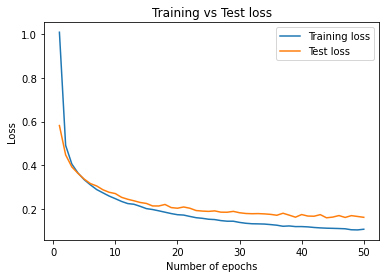

In [17]:
# plotting the test vs train loss curve
plt.plot(range(1, len(train_loss)+1), train_loss, label = "Training loss")
plt.plot(range(1, len(test_loss)+1), test_loss, label = "Test loss")
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title("Training vs Test loss")
plt.legend()
plt.show()

In [26]:
# checking our results visually on the pred_set
def Check_model(start):  # from which example we have to plot
  fig = plt.figure(figsize=(16,4))
  for i in range(16):
    img_num = start + i
    input = (torch.tensor(pred_dataset[img_num,:])/255.0).to(device)
    op = model(input)
    pred = op.argmax().item()
    fig.add_subplot(2,8,i+1)
    input = input.to('cpu') # have to add this line as input was on gpu
    plt.imshow(input.reshape([28,28]), cmap = 'gray')
    plt.title(pred)
    plt.axis('off')

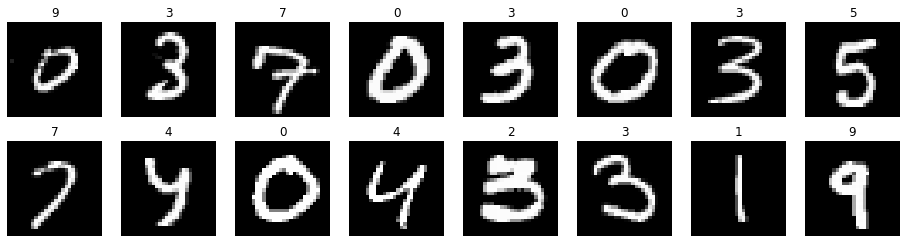

In [27]:
Check_model(3)  # model is performing quite well on the test set(acc=0.95) and on the pred set(by seeing the visualizations)

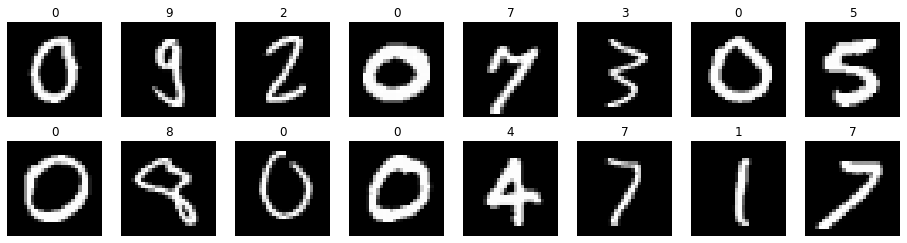

In [28]:
Check_model(100)

In [24]:
# predictions on the pred datset
def pred():
  image_id = np.arange(1, pred_dataset.shape[0]+1).reshape(pred_dataset.shape[0],1)
  res = np.zeros((pred_dataset.shape[0],1))
  for i in range(pred_dataset.shape[0]):
    input = (torch.tensor(pred_dataset[i,:])/255.0).to(device)
    op = model(input)
    ans = op.argmax().item()
    res[i] = ans
  pred_df = pd.DataFrame(np.concatenate((image_id.astype(np.int), res.astype(np.int)), axis=1))
  pred_df.columns = ['ImageId', 'Label']
  return pred_df

In [25]:
pred_df = pred()
pred_df.head()

C:\Users\Ayush\AppData\Local\Temp/ipykernel_13568/1949015779.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_df = pd.DataFrame(np.concatenate((image_id.astype(np.int), res.astype(np.int)), axis=1))


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [29]:
# model is performing well, so let's make a submission
submission = pred_df.to_csv('Submission.csv')